# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# Make a request
url_main = 'https://www.topuniversities.com'  # Found with postman
r = requests.get(url_main + '/sites/default/files/qs-rankings-data/357051.txt')
print('Response status code: {0}\n'.format(r.status_code))
page_body = r.text

# Serialize the json data with json library
rank_json = json.loads(page_body)

Response status code: 200



In [3]:
rank_df = pd.DataFrame()
rank_df = rank_df.from_dict(rank_json['data']).head(200)
rank_df.stars
rank_df.drop(['logo', 'stars', 'nid','cc', 'score'], axis=1, inplace=True)
rank_df.set_index('core_id', inplace=True)
rank_df = rank_df[['title', 'rank_display', 'country', 'region', 'url']]
rank_df.head()

,title,rank_display,country,region,url
core_id,,,,,
410,Massachusetts Institute of Technology (MIT),1,United States,North America,/universities/massachusetts-institute-technolo...
573,Stanford University,2,United States,North America,/universities/stanford-university
253,Harvard University,3,United States,North America,/universities/harvard-university
94,California Institute of Technology (Caltech),4,United States,North America,/universities/california-institute-technology-...
95,University of Cambridge,5,United Kingdom,Europe,/universities/university-cambridge


In [4]:
def my_find(html_attributes, new_df_column_name, rank_df):
    # this function accepts the HTML attributes <_tag, _class> of the tag to find inside every HTML page
    # whose URL is in rank_df['url']
    # Once the tag is found, it appends to the dataframe returned the value found inside the corresponding
    # <_tag, 'number'> attribute.
    # It returns a Dataframe with the column name passed by the parameter 'new_df_column_name'
    
    _tag = html_attributes['tag']
    _class = html_attributes['class']
    _list = []
    for url in rank_df.url:
        uni_url = requests.get(url_main + url)
        uni_body = uni_url.text
        soup = BeautifulSoup(uni_body, 'html.parser')
        soup1 = soup.find(_tag, class_=_class)
        if soup1:
            soup2 = soup1.find(_tag, class_='number')
            if soup2:
                _list.append({new_df_column_name: soup2.text})
            else:
                _list.append({new_df_column_name: -99})
        else:
            _list.append({new_df_column_name: -99})
    return pd.DataFrame.from_dict(_list).replace({r'\n': ''}, regex=True).replace({r',': ''}, regex=True).apply(pd.to_numeric).astype(int)

In [5]:
# defining HTML tag and class attributes that we want to find
tofind = [{'tag':'div', 'class': 'total faculty'}, 
          {'tag':'div', 'class': 'inter faculty'}, 
          {'tag':'div', 'class': 'total student'}, 
          {'tag':'div', 'class': 'total inter'}]

# creating DataFrame with the data found (NaN values = -99)
details_df = pd.concat([my_find(tofind[0], 'fac_memb_tot', rank_df),
                        my_find(tofind[1], 'fac_memb_int', rank_df),
                        my_find(tofind[2], 'nb_stud_tot', rank_df),
                        my_find(tofind[3], 'nb_stud_int', rank_df)], axis=1)

# concatenate the DataFrames into a unique one
details_df.set_index(rank_df.index, inplace=True)
qs_df = pd.concat([rank_df, details_df], axis=1)

# cleaning the unique DataFrame (deleting the = in rank_display)
qs_df.drop(['url'], axis=1, inplace=True)
qs_df.rank_display = qs_df.rank_display.replace({r'=': ''}, regex=True).apply(pd.to_numeric).astype(int)

# Creating the faculty_members_ratio and number_of_students ratio
qs_df['fac_memb_ratio'] = qs_df.fac_memb_tot / qs_df.nb_stud_tot
qs_df['int_stud_ratio'] = qs_df.nb_stud_int / qs_df.nb_stud_tot
qs_df

,title,rank_display,country,region,fac_memb_tot,fac_memb_int,nb_stud_tot,nb_stud_int,fac_memb_ratio,int_stud_ratio
core_id,,,,,,,,,,
410,Massachusetts Institute of Technology (MIT),1,United States,North America,2982,1679,11067,3717,0.269450,0.335863
573,Stanford University,2,United States,North America,4285,2042,15878,3611,0.269870,0.227422
253,Harvard University,3,United States,North America,4350,1311,22429,5266,0.193945,0.234785
94,California Institute of Technology (Caltech),4,United States,North America,953,350,2255,647,0.422616,0.286918
95,University of Cambridge,5,United Kingdom,Europe,5490,2278,18770,6699,0.292488,0.356899
478,University of Oxford,6,United Kingdom,Europe,6750,2964,19720,7353,0.342292,0.372870
365,UCL (University College London),7,United Kingdom,Europe,6345,2554,31080,14854,0.204151,0.477928
356,Imperial College London,8,United Kingdom,Europe,3930,2071,16090,8746,0.244251,0.543567
120,University of Chicago,9,United States,North America,2449,635,13557,3379,0.180645,0.249244


In [6]:
# Create a new feature: Total number of people in campus
qs_df['total_stud_facmemb'] = qs_df.fac_memb_tot + qs_df.nb_stud_tot

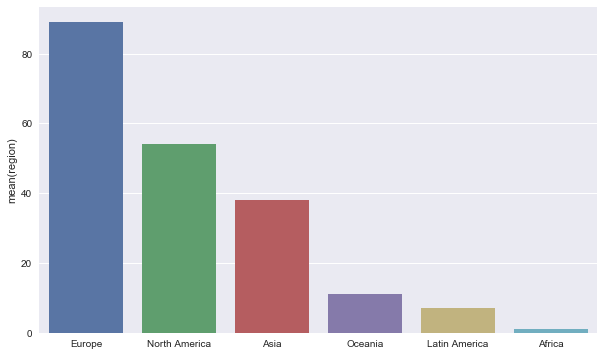

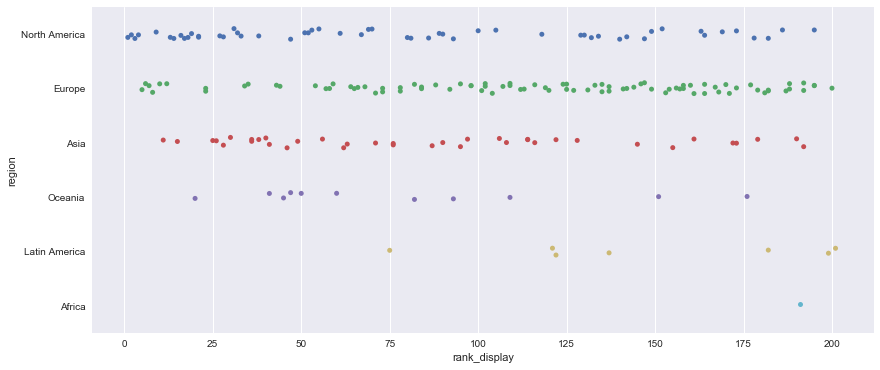

In [7]:
# Visualize how many universitie sper country are there in the best 200 ranking
plt.figure(figsize=(10,6))
regions = qs_df.region.value_counts().index
ax= sns.barplot(x=regions, y=qs_df.region.value_counts())

# Rank distribution per region
plt.figure(figsize=(14,6))
sns.stripplot(x="rank_display", y="region", data=qs_df, jitter=True)

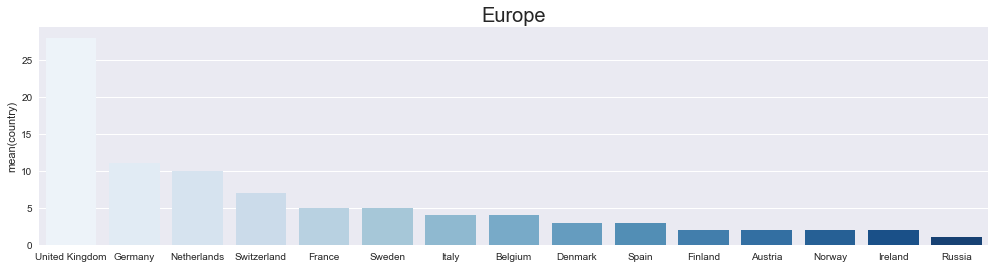

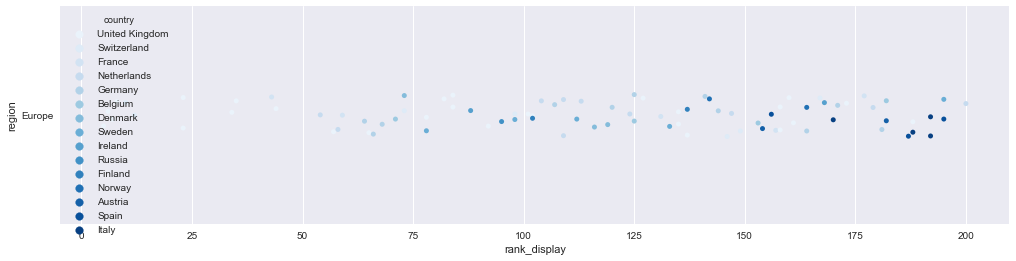

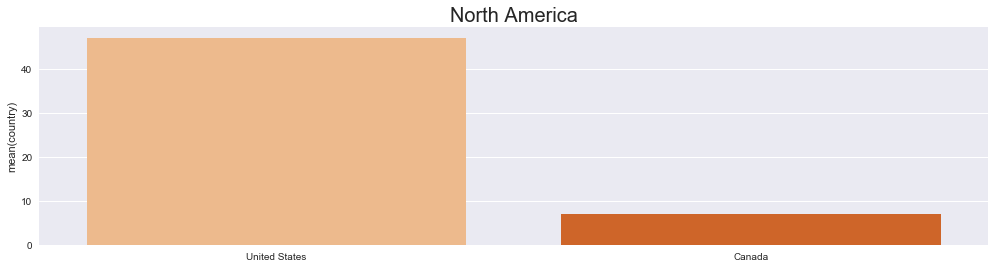

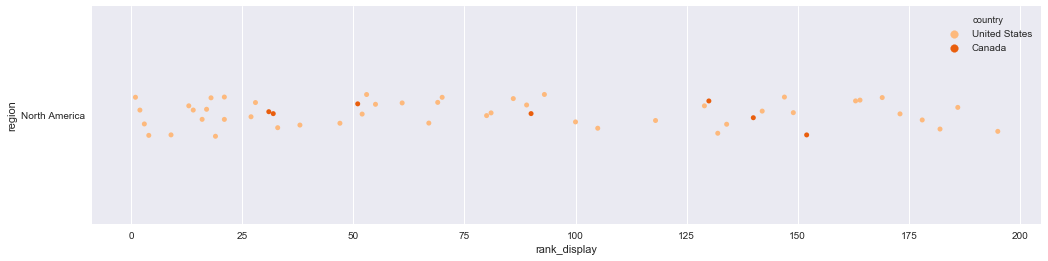

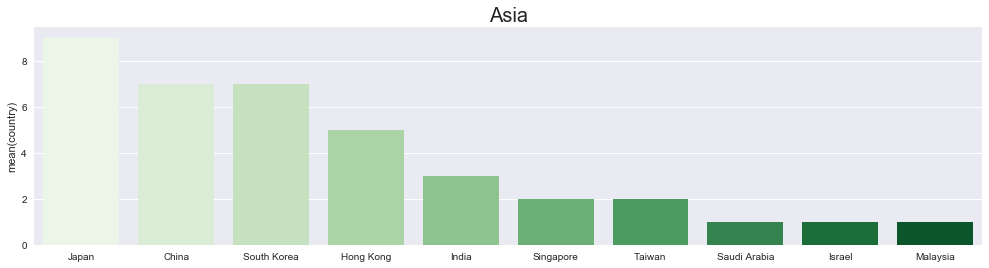

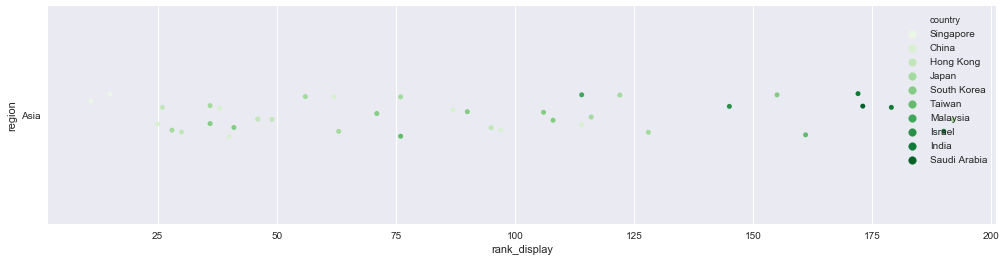

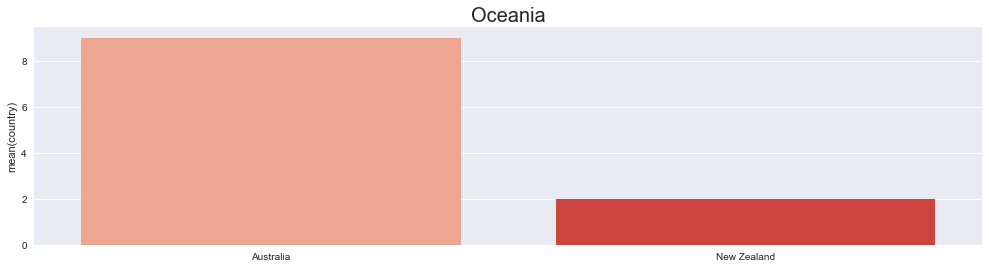

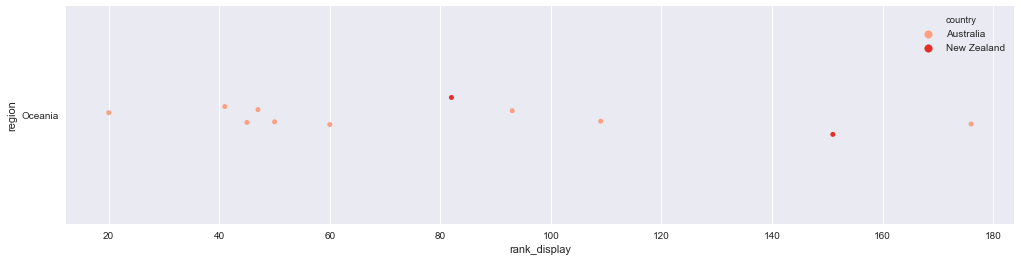

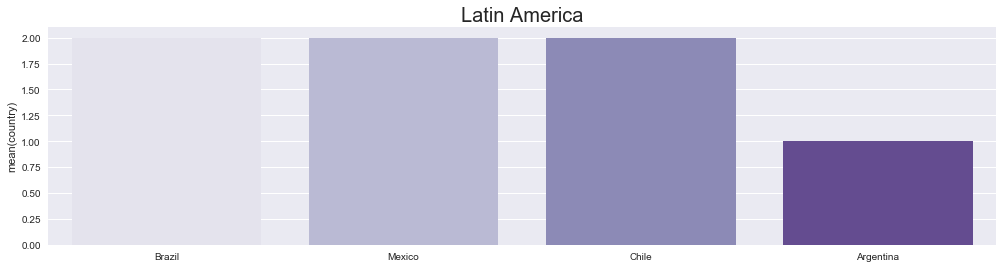

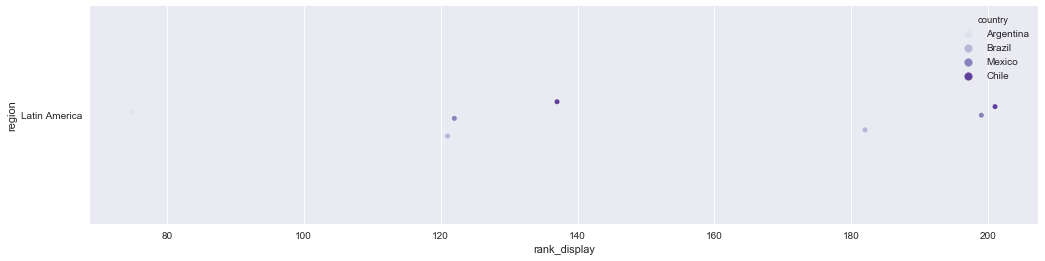

In [8]:
# Best 5 universities in Europe   
colors = ['Blues','Oranges', 'Greens', 'Reds','Purples']
for region, color in zip(regions, colors):
    plt.figure(figsize=(17,4))
    x = qs_df.country[qs_df.region==region].value_counts().index
    y = qs_df.country[qs_df.region==region].value_counts()
    ax= sns.barplot(x=x, y=y, palette=color)
    plt.title(region, fontsize=20)
    
    plt.figure(figsize=(17,4))
    sns.stripplot(x="rank_display", y="region", data=qs_df[qs_df.region==region], jitter=True, hue="country", palette=color)

In [9]:
# Drop the lines with negative values ()
qs_df = qs_df.drop(qs_df[qs_df.fac_memb_int == -99].index, axis=0)

# Describe the data
qs_df.describe()

,rank_display,fac_memb_tot,fac_memb_int,nb_stud_tot,nb_stud_int,fac_memb_ratio,int_stud_ratio,total_stud_facmemb
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,100.035354,2925.525253,786.409091,25818.414141,5103.671717,0.126065,0.211759,28743.939394
std,57.608461,2007.977599,666.690652,17109.328009,3918.157945,0.060589,0.116049,18686.068742
min,1.000000,86.000000,1.000000,532.000000,48.000000,0.040391,0.009892,618.000000
25%,50.250000,1674.000000,327.000000,15449.500000,2636.750000,0.084646,0.123716,17612.500000
50%,100.500000,2625.000000,599.500000,23777.500000,4280.500000,0.115368,0.194800,26592.500000
75%,149.000000,3639.750000,1027.750000,32226.500000,6883.750000,0.148596,0.280313,35779.750000
max,201.000000,16421.000000,3905.000000,141939.000000,27109.000000,0.422616,0.691393,157012.000000


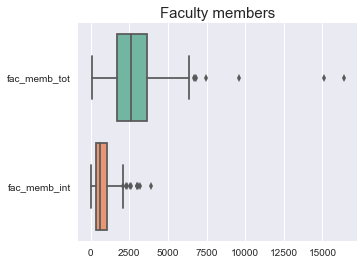

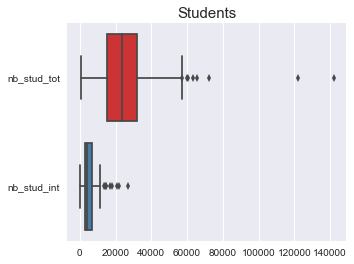

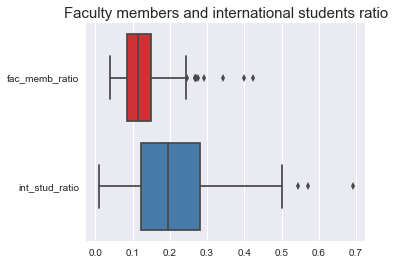

In [10]:
# Visualize the faculty members with a boxplot
plt.figure(figsize=(5,4))
sns.boxplot(data=qs_df[['fac_memb_tot', 'fac_memb_int']], orient="h", palette="Set2")
plt.title("Faculty members", fontsize=15)

# Visualize the students number with a boxplot
plt.figure(figsize=(5,4))
sns.boxplot(data=qs_df[['nb_stud_tot', 'nb_stud_int']], orient="h", palette="Set1")
plt.title("Students", fontsize=15)

# Visualize the ratios with a boxplot
plt.figure(figsize=(5,4))
ax1 = sns.boxplot(data=qs_df[['fac_memb_ratio', 'int_stud_ratio']], orient="h", palette="Set1")
plt.title("Faculty members and international students ratio", fontsize=15)

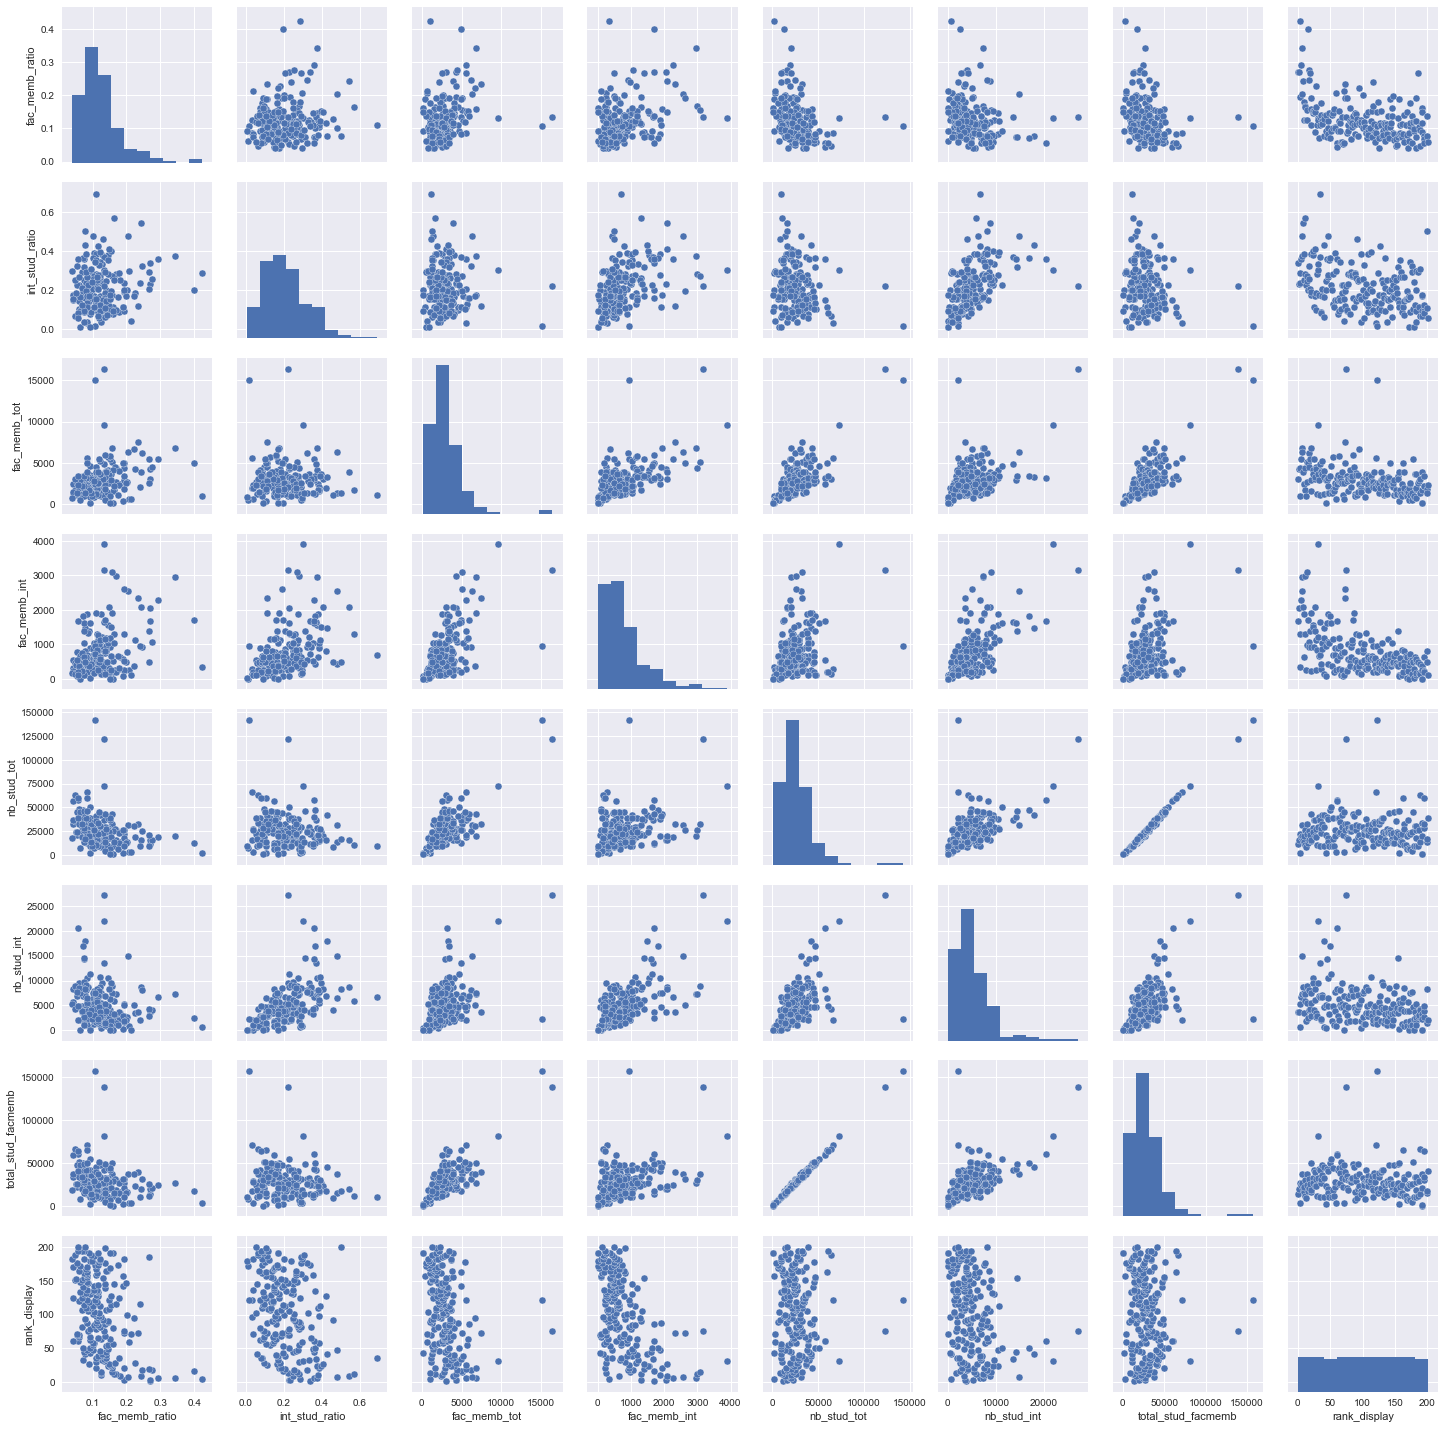

In [11]:
plt.figure(figsize=(7,4))
df = qs_df[['fac_memb_ratio', 'int_stud_ratio', 'fac_memb_tot', 'fac_memb_int', 'nb_stud_tot', 'nb_stud_int','total_stud_facmemb', 'rank_display']]
sns.pairplot(df)


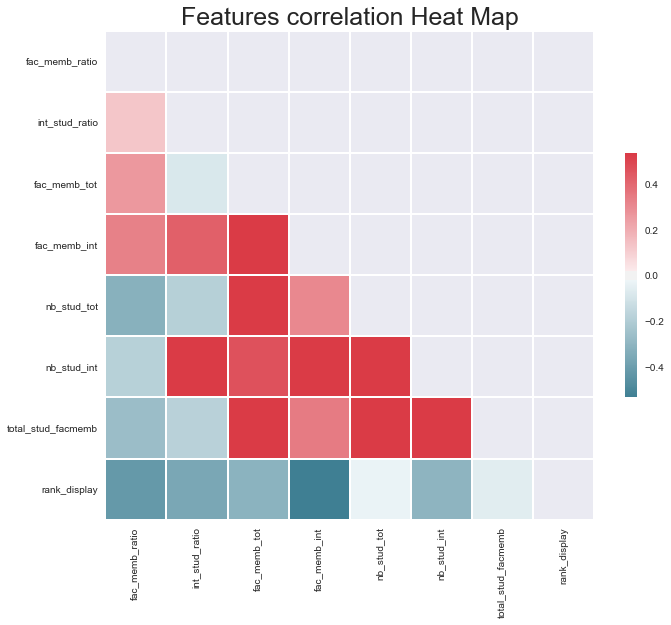

In [12]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5})

plt.title("Features correlation Heat Map", fontsize=25)

We can observe that the feature with more negative correlation with the rank of the university is the number of international students. In other words, as more international studets has a university, more well placed in the ranking will be.
In the same way, if the faculty members ratio is higher, the university will be better places in the ranking.